# 선형 모델 적합화를 위한 권장 절차 

In [ ]:
# 1. 데이터 셋이 깨끗하고 예상한 구조인지 확인
# 2. 변수의 분포를 확인해 많이 치우쳐 있지 않은지 확인, 삐뚤어진 경우 변환 고려
# 3. 이변량 산점도와 상관 행령을 조사해 매우 상관된 변수가 있는지 확인
#    있다면 일부 변수를 생략하거나 필요한 경우 변환 (8.1에서 더 자세하게)
# 4. 일관된 척도로 계수를 추정하려면 데이터 표준화
# 5. 모델을 적합화한 후 출력에서 "잔차 분위수" 확인. 
#    잔차는 모델이 개별 관측치를 얼마나 잘 설명하는지 보여줌. -> 대칭 혹은 정규 분포일 경우 모델이 편향되지 않았음을 나타냄
#    (잔차 표준 오차는 더 단순한 모델의 경우 숫자가 클수록 더 예측이 정확하다는 것을 알려주고, 더 단순한 모델일수록 큼)
# 6. 적합도의 진단 우수성을 평가해 표준 모델 도면을 확인하면 선형 모델인지 여부를 판단하는데 도움을 줌
#    이를 통해, 선형의 적절성과 함께 비선형성이 있는지 여부를 확인하고 데이터에서 잠재적인 특이치를 식별
# 7. 여러 모델을 시도하고, 잔차의 산포와 전체적인 r-squared를 조사해 전체적인 해석 가능성과 모델 적합성을 비교
#    모델이 중첩된 경우 비교를 위해 ANOVA 사용
#    변수 간의 상호작용도 고려.
# 8. 해석 및 권장 사항과 함께 추정치의 신뢰 구간 보고

# 놀이공원 데이터

In [1]:
# 선형모델

# 설문조사 데이터를 바탕으로 만족도 동인 분석을 통해 선형 모델링 설명
# 어떤 고객 경험 측면이 전반적인 만족도를 높이는지 파악하기

In [3]:
# 예시 데이터 import
import pandas as pd
sat_df = pd.read_csv('http://bit.ly/PMR-ch7')
sat_df.head()

,is_weekend,num_child,distance,rides,games,wait,clean,overall
0,True,0,9.844503,82.0,64.0,82.0,88.0,68.0
1,False,1,2.720221,85.0,83.0,100.0,90.0,100.0
2,False,3,1.878189,88.0,81.0,80.0,91.0,95.0
3,False,0,14.211682,73.0,52.0,68.0,74.0,55.0
4,False,1,9.362776,78.0,93.0,56.0,82.0,63.0


In [4]:
# describe로 데이터 살펴보기

sat_df.describe().round(2)

,num_child,distance,rides,games,wait,clean,overall
count,500.00,500.00,500.00,500.00,500.00,500.00,500.00
mean,1.75,31.58,80.18,73.96,73.32,85.25,75.34
std,1.53,35.77,6.02,8.74,10.70,5.73,12.16
min,0.00,0.64,64.00,44.00,46.00,65.00,42.00
25%,0.00,9.07,76.00,68.00,66.00,82.00,67.00
50%,2.00,19.26,80.00,74.00,73.00,85.00,76.00
75%,3.00,39.01,84.00,80.00,80.00,89.00,85.00
max,5.00,233.30,99.00,100.00,100.00,100.00,100.00


## ols로 선형모델 적합화

### 예비데이터 검사

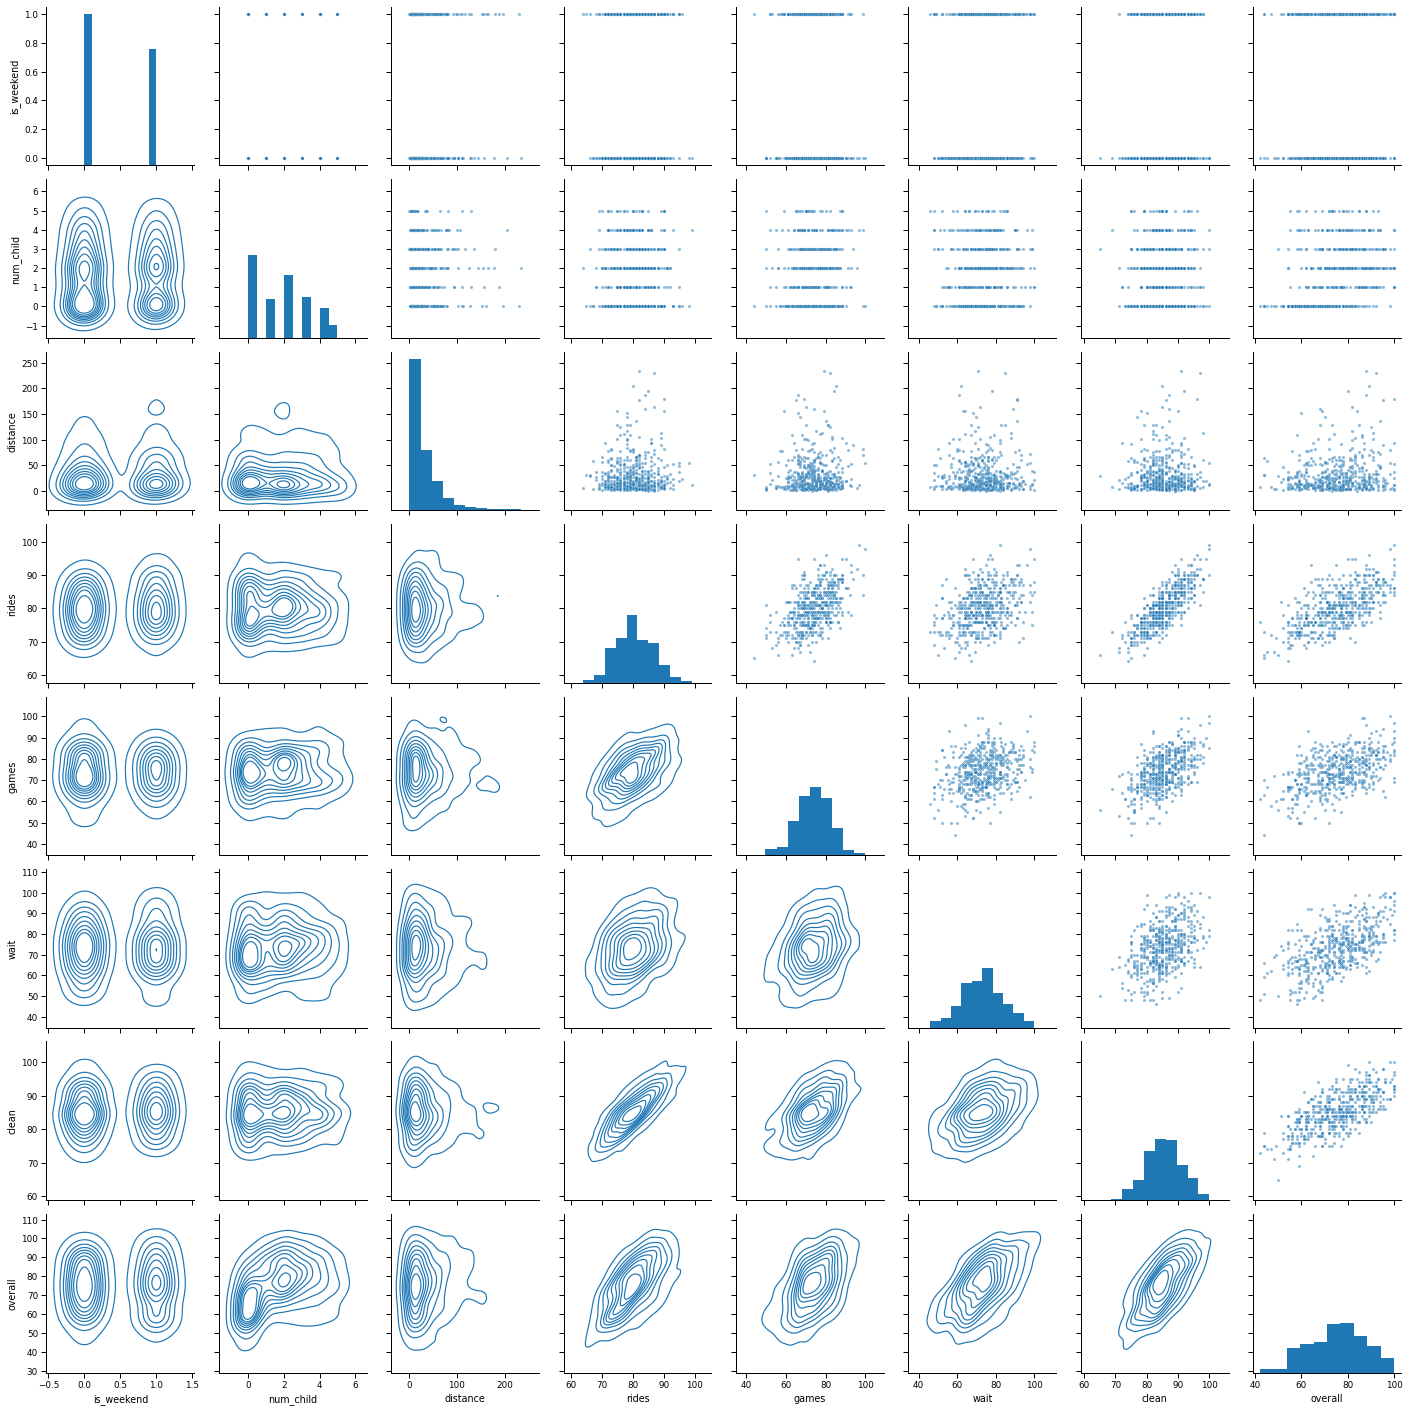

In [6]:
# 모델링하기 전에 확인해야 될점
# 1. 각 개별 변수가 합리적인 분포를 갖고 있는지
# 2. 변수 간의 공동 관계가 모델링에 적합한지

import seaborn as sns
sns.set_context('paper')
import matplotlib.pyplot as plt
g = sns.PairGrid(sat_df.replace({False:0, True:1}))
g.map_upper(sns.scatterplot, linewidths=1, edgecolor = 'w', s=10, alpha=.5)
g.map_diag(plt.hist)
g.map_lower(sns.kdeplot)

In [7]:
# 치우친 분포 log를 가져와 변환
sat_df['log_dist'] = sat_df.distance.apply(np.log)

<AxesSubplot:>

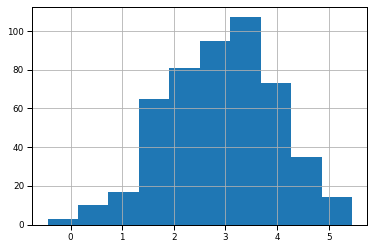

In [8]:
sat_df['log_dist'].hist()

In [9]:
# 산점도를 보면 서로 양의 관계를 가지고 있는 변수들의 있음
# 높은 상관관계를 가질 수도 있는 문제가 있음
# 독립적으로 평가되야 할 변수들이 독립적으로 평가가 되지 않았을 수 있음
# 전반적인 후광 등급을 형성하고 그 전체적인 느낌에 비춰 각 개별 원소 경험을 평가했을 수 있음

<AxesSubplot:>

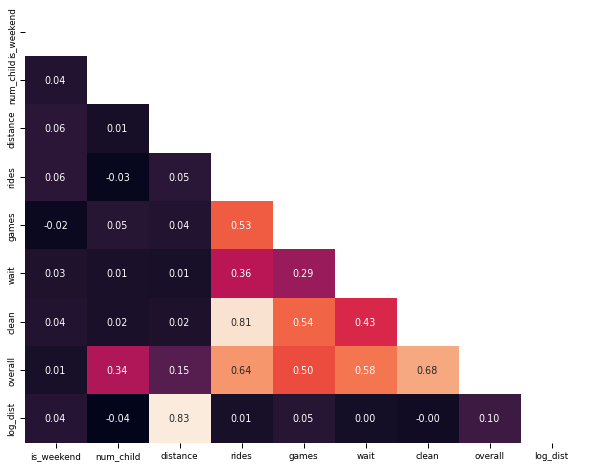

In [15]:
# 상관관계 파악
corr = sat_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', 
            mask = np.triu(np.ones_like(corr)),
            cbar=False)

# r > 0.8을 초과하거나 특정 쌍에 대해 r > 0.9를 초과하는 경우 크게 없음
# 놀이기구와 청결도는 관련성이 높지만 개선이 엄격하게 요구될 정도로 강력하지는 않음

# 8장에서 높은 상관관계가 심각한 문제를 일으킬 경우 해야할 일 배움
# 9장에서는 상관관계가 높은 데이터에서 나타나는 기본 차원을 찾는 전략 설명

### 이변량 연관성

Text(0, 0.5, 'Satisfaction overall')

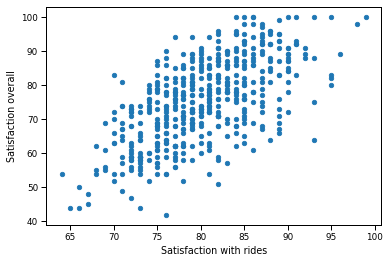

In [17]:
# 만족도 동인 분석의 목표는 서비스의 특징에 대한 고객 만족도와 전반적인 경험 간의 관계를 발견하는 것
# 상관관계가 약한가? 큰가?

sat_df.plot(kind='scatter', x='rides', y='overall')
plt.xlabel('Satisfaction with rides')
plt.ylabel('Satisfaction overall')

In [19]:
# ols로 선형모델 만들기

import statsmodels.formula.api as smf
temp_model = smf.ols('overall ~ rides', data=sat_df).fit()
temp_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     341.3
Date:                Sat, 25 Feb 2023   Prob (F-statistic):           2.02e-58
Time:                        16:28:53   Log-Likelihood:                -1827.7
No. Observations:                 500   AIC:                             3659.
Df Residuals:                     498   BIC:                             3668.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -27.9869      5.609     -4.990      0.000     -39.007     -16.967
rides          1.2887      0.070     18.474      0.000       1.152       1.426
==============================================================================
Omnibus:                        5.897   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                5.361
Skew:                          -0.194   Prob(JB):                       0.0685
Kurtosis:                       2.674   Cond. No.                     1.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# 모델의 세부사항을 보기 위한 summary를 통해 확인할 점
# R-squared, P > |t|
# coef 열의 모델 계수 -> rides에 대한 각 추가 평가 점수는 overall 점수를 1.2887점 증가시키는 것으로 추정된다
# (intercept 계수는 일반적으로 만족도 동인 분석에서 해석할 수 없음)
# std err 열은 데이터가 더 큰 모집단의 무작위 표본이라는 가정하에 계수 추정치의 불확실성을 나타냄  
# 계수 추정치에 대한 95% 신뢰 구간의 전통적인 추정치는 +- 1.96 * std.error 내에 속한다는 것
# F 통계량으로 나타난 부분 -> p값이 < 0.05 이므로 예측변수가 없는 모델이 모델 m1만큼 성능을 발휘한다는 귀무가설을 기각

### ols 객체

In [21]:
m1 = smf.ols('overall ~ rides', data=sat_df).fit()

In [24]:
# 계수에 접근
m1.params

Intercept   -27.986876
rides         1.288694
dtype: float64

In [29]:
# predict를 사용하여 모델에 기반한 overall 추정치 구하기 
m1.predict({'rides':[95, 90]})

0    94.439017
1    87.995549
dtype: float64

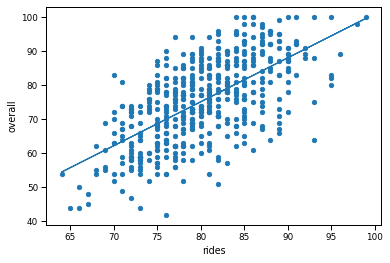

In [32]:
sat_df.plot(kind='scatter', x='rides', y='overall')
plt.plot(sat_df.rides, m1.predict(sat_df.rides))

In [36]:
# 신뢰구간 구하기
# 단일 최적점이 아닌 추정 범위를 보고하는 것이 가장 좋음
m1.conf_int()

,0,1
Intercept,-39.006778,-16.966974
rides,1.151636,1.425752


### 잔차

In [37]:
# 잔차 검사
# 모델에서 예측한 포인트 값과 실제 값 간의 차이
# 범위가 매우 넓으므로 주어진 데이터 포인트에 대해 예측이 다소 틀릴 수 있음을 의미함 

m1.resid.max(), m1.resid.min()

(22.75746829230569, -27.953838097780633)

(array([ 3., 12., 29., 55., 94., 97., 91., 78., 32.,  9.]),
 array([-27.9538381 , -22.88270746, -17.81157682, -12.74044618,
         -7.66931554,  -2.5981849 ,   2.47294574,   7.54407638,
         12.61520701,  17.68633765,  22.75746829]),
 <BarContainer object of 10 artists>)

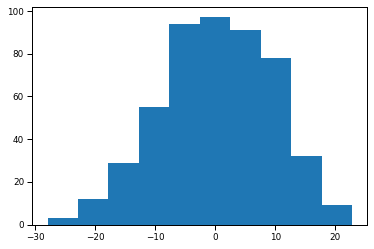

In [38]:
# 잔차 시각화
# 모델이 편향되지 않아 좋은 신호일 수 있음
plt.hist(m1.resid)

In [39]:
# 잔차의 표준편차
# 값 자체는 별로 유용하지 않지만, 7.3에서 볼 때 모델을 비교하는데 유용할 수 있음
np.std(m1.resid)

9.360403552873871

### 모델 적합 확인

In [40]:
# 선형 모델을 적합화할 때는 몇가지 가정이 있어야 함
# 1. 예측 변수와 결과 간의 관계가 선형
# 관계가 선형이 아닌 경우 모델은 체계적인 오류를 만듬
# 때문에 먼저 x 대 y를 도식화한 다음 도면에 적합선을 그리면 무슨 일이 일어나고 있는지 명확하게 알 수 있음

# 2. 예측 오차가 정규 분포를 따르고 패턴이 없는 랜덤 노이즈처럼 보이다는 것
# 한 가지 방법은 모델의 적합화 값대 잔차를 그리는 것

In [41]:
# 예시 데이터
x = np.random.normal(size=500)
y = x**2 + np.random.normal(size=500)
toy_model = smf.ols('y~x', data={'x':x, 'y':y}).fit()
toy_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.730
Date:                Sat, 25 Feb 2023   Prob (F-statistic):              0.189
Time:                        16:53:32   Log-Likelihood:                -1011.1
No. Observations:                 500   AIC:                             2026.
Df Residuals:                     498   BIC:                             2035.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0505      0.082     12.822      0.000       0.890       1.211
x              0.1072      0.081      1.315      0.189      -0.053       0.267
==============================================================================
Omnibus:                      267.789   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2664.111
Skew:                           2.126   Prob(JB):                         0.00
Kurtosis:                      13.478   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Predicted y values vs Residuals')

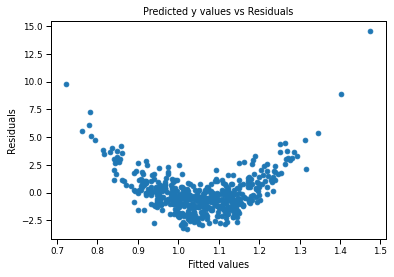

In [42]:
# 잔차에 명확한 패턴이 있음을 알 수 있음

plt.scatter(x=toy_model.fittedvalues, y=toy_model.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Predicted y values vs Residuals')

In [43]:
# 실제로 위 데이터를 마주치면 그 해결책은 일반적으로 x를 변환하는 것

In [52]:
# 적합치 대 잔차 그림 그리기

from statsmodels.graphics import gofplots
from statsmodels.graphics import regressionplots

def plot_gof_figures(model):
    
    """
    적합화 도면의 적절성을 보여주는 다중 패널 도면
    """
    
    sns.residplot(x = model.fittedvalues, y = model.resid, lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted')
    plt.show()
    
    _ = gofplots.qqplot(model.resid, fit=True, line='45')
    plt.title('Normal Q-Q')
    plt.show()
    
    plt.scatter(x=model.fittedvalues, y=np.abs(model.resid)**.5)
    plt.xlabel('Fitted values')
    plt.ylabel('Square root of the standardlized residuals')
    plt.title('Scale-Location')
    plt.show()
    
    regressionplots.plot_leverage_resid2(model)

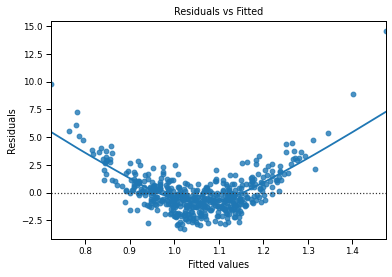

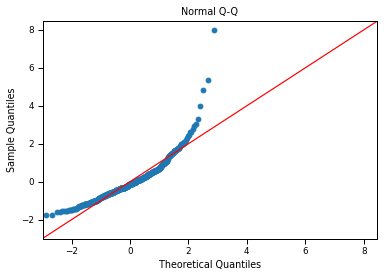

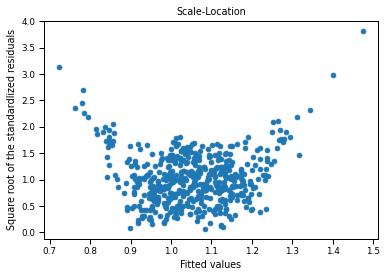

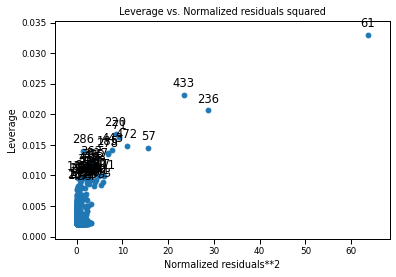

In [53]:
plot_gof_figures(toy_model)

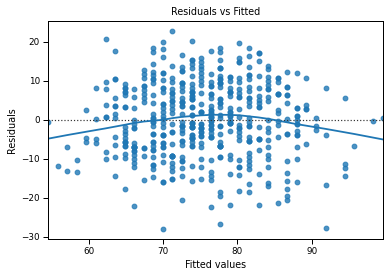

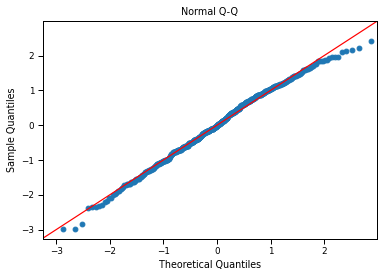

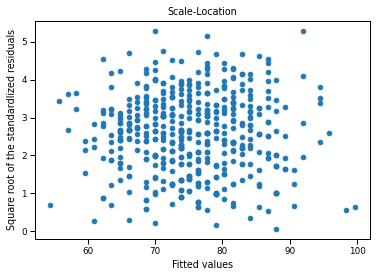

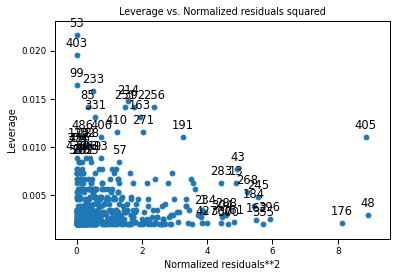

In [54]:
# 적합치와 잔차 사이에 명확한 패턴이 없음
# 이는 잔차가 무작위 오차에 기인한 것이라는 생각과 일치
# 모델이 합릭적이고 명백한 비선형성을 무시하지 않는다는 개념을 뒷받침함

# 세번째 그림: 잔차 절대값의 제곱근 (표준화 잔차)
# 명확한 패턴이 없어야 됨 -> 있다면 비선형 관계를 암시

# 두번째 그림 : qqplot
# 잔차가 정규 분포를 따르는지 여부를 확인하는데데 도움을 줌 
# 변수 간의 관계가 비선형하거나 가정과 일치하지 않으면 점이 대각에서 벗어난다

# 네번째 그림: 잠재적 특이치, 즉 다른 분포에서 나올 수 있는 관측치를 식별하는데 다시 도움을 줌
# 특이치는 다른 점에서 멀리 떨어져 있으면 적합선에 과도하게 영향을 미치기 때문에 문제가 됨
# 포인트의 레버리지(leverage)는 포인트가 모델 계수에 미치는 영향을 보여줌
# 잔차와 레버리지가 높으면 포인트가 다른 패터과 과도한 영향 모두를 가지고 있음을 나타냄
# 포인트가 고표준화된 잔차 거리와 모델 레버지리를 기반으로 잠재적으로 문제가 되는 특이치인 경우 자동으로 행 번호로 레이블이 지정됨
# 해당 점 검사 가능 (밑에 셀에서)

plot_gof_figures(m1)

In [55]:
# 데이터가 명백한 오류를 나타내는 경우를 제외하고는 일반적으로 특이치를 생략하지 않음
# 현재는 모든 관측치 유지
sat_df.loc[[405, 48, 176]]

,is_weekend,num_child,distance,rides,games,wait,clean,overall,log_dist
405,True,0,11.445116,93.0,77.0,75.0,89.0,64.0,2.437563
48,False,0,8.434066,76.0,61.0,48.0,73.0,42.0,2.132279
176,True,0,18.318936,82.0,61.0,74.0,84.0,51.0,2.907935


In [56]:
# 지금까지 하나의 변수만 조사했으므로 다음 절에서 여러 예측 변수 조사

## 다중 예측차작 있는 선형 모델 적합화

In [57]:
# 복수의 만족 동인을 평가하는 문제로 넘어가기
# 놀이기구, 게임, 대기 시간, 청결 등 공원의 "모든 특징을 분류해" 전반적인 만족도와 가장 밀렵한 관련이 있는 특징 결정

In [58]:
# ols 호출
# R 제곱이 증가
m2 = smf.ols('overall ~ rides + games + wait + clean', 
             data=sat_df).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     181.9
Date:                Sat, 25 Feb 2023   Prob (F-statistic):           9.91e-96
Time:                        17:22:11   Log-Likelihood:                -1732.2
No. Observations:                 500   AIC:                             3474.
Df Residuals:                     495   BIC:                             3495.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -53.6088      5.246    -10.219      0.000     -63.916     -43.302
rides          0.4256      0.099      4.279      0.000       0.230       0.621
games          0.1861      0.048      3.843      0.000       0.091       0.281
wait           0.3842      0.036     10.647      0.000       0.313       0.455
clean          0.6205      0.108      5.725      0.000       0.408       0.834
==============================================================================
Omnibus:                       12.515   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.113
Skew:                          -0.390   Prob(JB):                      0.00142
Kurtosis:                       2.854   Cond. No.                     2.37e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [59]:
# m1의 잔차 표준 오차
np.std(m1.resid)

9.360403552873871

In [61]:
# m2의 잔차 표준 오차
# 숫자가 더 작아졌으므로, 예측이 덜 정확해졌음을 알 수 있음
np.std(m2.resid)

7.732470220113993

In [63]:
# 모델 계수 조사
# 계수 시각화

!pip install python_marketing_research
from python_marketing_research_functions import chapter6

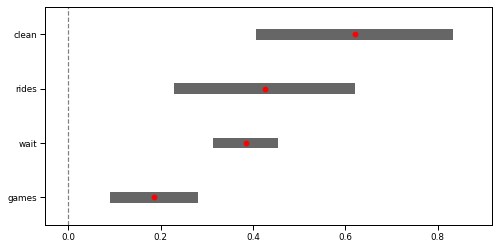

In [64]:
# 청결에 대한 만족도가 전반적인 만족도와 관련된 가장 중요한 특징으로 추정됨
# wait (대기 시간) 대 rides (놀이기구)의 상대적 중요성은 덜 명확함

# 이러한 계수 도면은 종종 만족도 동인 분석의 핵심 결과임
# 예측 계수를 기반으로 계수가 순선대로 정렬되도록 도면을 정렬하면 예측 변수가 많은 경우,
# 전체 만족도와 가장 밀접하게 관련된 특징을 더 쉽게 식별 가능

chapter6.plot_confidence_intervals(m2.params[1:],
                                   m2.conf_int().iloc[1:,:],
                                   zero_line=True)

### 모델비교

In [65]:
# m1과 m2 비교
# 모델을 비교하는 방법
# 1. r-squared 값 비교

In [66]:
print(m1.rsquared)
print(m2.rsquared)

0.4066280681606047
0.5950752098970707


In [67]:
# adjusted r-squared
# m2가 전체 만족도의 변동을 더 많이 설명한다는 것을 암시함

print(m1.rsquared_adj)
print(m2.rsquared_adj)

0.40543655825731273
0.5918030903810875


In [68]:
# 모델 예측 시각화
# 적합 값과 실제 값 도칙화

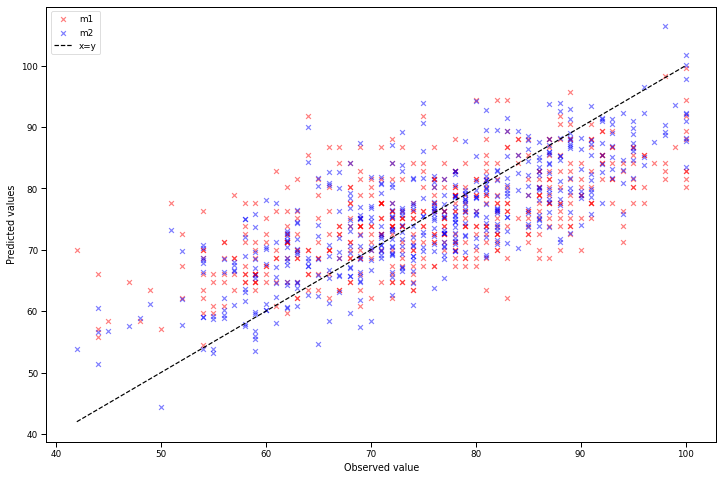

In [70]:
# 파란색 점 구름이 대각선을 따라 더 밀집돼 있음을 알 수 있음
# m2가 m1보다 데이터의 변동을 더 많이 설명한다는 것을 보여줌

plt.figure(figsize=(12, 8))
plt.scatter(
    sat_df.overall,
    m1.fittedvalues,
    c='r',
    marker='x',
    alpha=.5,
    label='m1'
)
plt.scatter(
    sat_df.overall,
    m2.fittedvalues,
    c='b',
    marker='x',
    alpha=.5,
    label='m2'
)
satisfaction_range = [sat_df.overall.min(), sat_df.overall.max()]
plt.plot(satisfaction_range, satisfaction_range, '--k', label='x=y')
plt.xlabel('Observed value')
plt.ylabel('Predicted values')
plt.legend()

In [71]:
# 모델이 중첩돼 있기 때문에 anova_lm 사용해 m2가 m1보다 더 많은 변동을 설명하는 지 확인하기

In [72]:
# p값이 낮으면 m2의 추가 예측 변수가 모형의 적합도를 크게 향상시킨다는 것을 나타냄

from statsmodels.stats import anova as sms_anova
sms_anova.anova_lm(m2, m1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,495.0,29895.547852,0.0,NaN,NaN,NaN
1,498.0,43808.577336,-3.0,-13913.029484,52.719422,NaN


In [78]:
# m2의 rides 계수가 변경됨
# why? -> 놀이기구가 다른 모든 변수와 독립적이지 않기 때문
# 그렇다면 어떤 모델이 더 바람직한가? 
# -> 모델 m2가 전체적으로 더 잘 적합화하기 때문에 놀이기구에 대한 계수를 잘 해석하지만 전체 모델의 맥락에서만 해석됨
# 다음 절에서 모델의 구조가 변경되면 계수도 일반적으로 변경된다는 것을 볼 수 있음

print(m2.params, end='\n\n')
print(m1.params)

Intercept   -53.608804
rides         0.425558
games         0.186069
wait          0.384159
clean         0.620541
dtype: float64

Intercept   -27.986876
rides         1.288694
dtype: float64


### 모델을 사용해 예측하기

In [79]:
# 모델 예측 계산하기

In [81]:
m2.predict(sat_df.head(10))

0    79.303964
1    92.271882
2    86.113782
3    59.175321
4    69.286346
5    72.019136
6    79.708122
7    75.172110
8    75.774821
9    80.446600
dtype: float64

In [83]:
# fittedvalues를 사용해서도 추정가능

m2.fittedvalues[:10]

0    79.303964
1    92.271882
2    86.113782
3    59.175321
4    69.286346
5    72.019136
6    79.708122
7    75.172110
8    75.774821
9    80.446600
dtype: float64

In [84]:
# dict도 허용

m2.predict({'rides':100,
            'games':100,
            'wait':100,
            'clean':100})

0    108.023824
dtype: float64

### 예측치 표준화

In [ ]:
# 변수의 척도가 다른 설문 조사의 경우 계수 값을 직접 비교할 수 없음
# 계수를 비교하기 위해서는 모델을 적합화하기전에 공통 척도로 데이터를 표준화하면 좋음
# 가장 일반적인 표준화는 값을 0 중심의 표준 편차 단위로 변환
# 각 관측치에서 변수의 평균을 뺀 다음, 표준 편차로(std())로 나누기 -> z score

In [86]:
((sat_df.rides - sat_df.rides.mean())/sat_df.rides.std()).head(10)

0    0.302715
1    0.801147
2    1.299580
3   -1.192583
4   -0.361862
5    0.468859
6    0.136571
7   -0.361862
8   -0.029574
9   -0.528006
Name: rides, dtype: float64

In [89]:
# 변수의 크기에 대해 걱정하지 않고 상대적인 기여도만 고려한다면 크기 조정된 버전의 sat_df를 만들 수 있음
# 표준화할 때 원래 데이터프레임은 변경하지 않고 복사하여 사용하기
# 만족도 동인 분석에서는 일반적으로 서로 다른 예측 변수의 상대적 기여에 더 관심이 있고 이를 비교하고자 표준화함

sat_df_scaled = sat_df.copy()
idx = ['clean', 'games', 'rides', 'wait', 'log_dist', 'overall']
sat_df_scaled[idx] = (sat_df[idx] - sat_df[idx].mean(axis=0))/sat_df[idx].std(axis=0)
sat_df_scaled.head()

,is_weekend,num_child,distance,rides,games,wait,clean,overall,log_dist
0,True,0,9.844503,0.302715,-1.139289,0.811454,0.480319,-0.603270,-0.598161
1,False,1,2.720221,0.801147,1.034490,2.494194,0.829134,2.027508,-1.801954
2,False,3,1.878189,1.299580,0.805671,0.624483,1.003542,1.616449,-2.148627
3,False,0,14.211682,-1.192583,-2.512202,-0.497343,-1.961389,-1.672024,-0.254534
4,False,1,9.362776,-0.361862,2.178584,-1.619169,-0.566127,-1.014329,-0.645118


In [91]:
# 표준화되면 평균이 0이 되고 절편은 0이 됨
# 하지만 절편이 모델에서 제거가 될 수 있음을 의미하지는 않음
# 모형은 절편의 오류까지 포함해서 전체 적합치의 오류를 최소화하도록 추정된다
# 따라서 절편은 표준화 후에도 모델에 계속 남아있어야 됨

sat_df_scaled.describe()

,num_child,distance,rides,games,wait,clean,overall,log_dist
count,500.00000,500.000000,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02
mean,1.75000,31.583252,4.534151e-16,2.100542e-16,6.312728e-16,8.199136e-16,4.853895e-16,-2.799011e-15
std,1.53369,35.766452,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,0.00000,0.640780,-2.687881e+00,-3.427477e+00,-2.554025e+00,-3.531058e+00,-2.740777e+00,-3.155104e+00
25%,0.00000,9.067902,-6.941505e-01,-6.816513e-01,-6.843141e-01,-5.661273e-01,-6.854821e-01,-6.750689e-01
50%,2.00000,19.258191,-2.957367e-02,4.805195e-03,-2.991537e-02,-4.290429e-02,5.442422e-02,2.986748e-02
75%,3.00000,39.011249,6.350031e-01,6.912617e-01,6.244833e-01,6.547264e-01,7.943305e-01,6.905501e-01
max,5.00000,233.295565,3.127166e+00,2.979450e+00,2.494194e+00,2.573211e+00,2.027508e+00,2.364424e+00


## 요인을 예측자로 사용

In [ ]:
# m2를 좀 더 개선할 수 있음
# 최종 모델에 도달하기 전에 많은 모델을 시도하는 것은 일반적임
# 주말에 오거나 먼 곳을 여행하는 고객, 혹은 다자녀의 경우 만족도가 서로 다른지 확인해보기

In [94]:
# r-squared(적합도) 향상
# log_dist와 num_child에 대한 계수가 0보다 상당히 큰 것을 보여줌
# -> 더 멀리 여행하고 더 많은 자녀를 둔 사람들이 전반적인 만족도 등급이 더 높다는 것을 나타냄
m3 = smf.ols('overall ~ rides + games + wait + clean + is_weekend + log_dist + num_child', 
              data=sat_df_scaled).fit()
m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     176.3
Date:                Sat, 25 Feb 2023   Prob (F-statistic):          1.01e-129
Time:                        18:11:52   Log-Likelihood:                -395.18
No. Observations:                 500   AIC:                             806.4
Df Residuals:                     492   BIC:                             840.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.3516      0.042     -8.423      0.000      -0.434      -0.270
is_weekend[T.True]    -0.0724      0.049     -1.485      0.138      -0.168       0.023
rides                  0.2558      0.042      6.147      0.000       0.174       0.338
games                  0.0992      0.029      3.371      0.001       0.041       0.157
wait                   0.3363      0.027     12.591      0.000       0.284       0.389
clean                  0.2718      0.043      6.310      0.000       0.187       0.356
log_dist               0.1069      0.024      4.423      0.000       0.059       0.154
num_child              0.2190      0.016     13.864      0.000       0.188       0.250
==============================================================================
Omnibus:                        0.081   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.960   Jarque-Bera (JB):                0.163
Skew:                          -0.017   Prob(JB):                        0.922
Kurtosis:                       2.918   Cond. No.                         5.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [96]:
# 데이터의 유형에 주의
# num_child의 경우 0-5 범위의 숫자 변수이지만, m3에서 했던 것처럼 숫자로 취급하는 것이 반드시 의미가 있지는 않음
# 만약에 숫자로 인정한다면 아이들의 수의 함수에 따라 선형적으로 올라가거나 내려가고 그 효과는
# 각 추가 아동 수에 대해 동일하다고 묵시적으로 가정

# onehot코딩 이용

dummy_vals = pd.get_dummies(sat_df_scaled.num_child, prefix='num_child')
dummy_vals.head()

,num_child_0,num_child_1,num_child_2,num_child_3,num_child_4,num_child_5
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,0,1,0,0
3,1,0,0,0,0,0
4,0,1,0,0,0,0


In [97]:
sat_df_child_factor = sat_df_scaled.join(dummy_vals)
sat_df_child_factor

,is_weekend,num_child,distance,rides,games,wait,clean,overall,log_dist,num_child_0,num_child_1,num_child_2,num_child_3,num_child_4,num_child_5
0,True,0,9.844503,0.302715,-1.139289,0.811454,0.480319,-0.603270,-0.598161,1,0,0,0,0,0
1,False,1,2.720221,0.801147,1.034490,2.494194,0.829134,2.027508,-1.801954,0,1,0,0,0,0
2,False,3,1.878189,1.299580,0.805671,0.624483,1.003542,1.616449,-2.148627,0,0,0,1,0,0
3,False,0,14.211682,-1.192583,-2.512202,-0.497343,-1.961389,-1.672024,-0.254534,1,0,0,0,0,0
4,False,1,9.362776,-0.361862,2.178584,-1.619169,-0.566127,-1.014329,-0.645118,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,False,0,27.246295,-1.192583,-0.452832,-0.403857,-0.914943,-1.507600,0.354619,1,0,0,0,0,0
496,False,3,11.953974,-1.026439,-0.224014,0.344027,-1.089350,-0.027788,-0.416450,0,0,0,1,0,0
497,True,2,6.766467,0.136571,0.691262,1.559339,-0.566127,1.040966,-0.949073,0,0,1,0,0,0
498,True,3,54.541248,0.136571,-0.796061,-0.216886,-0.566127,-1.096541,1.004191,0,0,0,1,0,0


In [100]:
# num_child에 대해서 6개의 적합 계수가 있음을 확인 가능
# num_child_0에 대한 계수는 음수이므로 자녀가 없는 구룹이 점수가 더 낮다는 것을 나타냄
# num_child_1과 비교했을 때 1명의 자녀가 있는 그룹이 자녀가 없는 그룹보다 평균 1.0075 표준 편차로 전체 만족도를 더 높게 평가한다는 것을 암시

# But, 그룹에 있는 어린이 수에 관계없이 전반적인 만족도의 증가가 거의 동일하다는 것을 알 수 있음
# 이는 실제로 각 어린이 수의 증가를 다르게 추정할 필요가 없음을 시사함

# 1명의 아동이든 3명의 아동이든 모두 동일하게 증가하는 경우 아동당 점차 확장되는 모델을 적합화하려면 추정치의 정확도가 떨어짐

m4 = smf.ols(
    'overall ~ rides + games + wait + clean + is_weekend + log_dist +\
    num_child_0 + num_child_1 + num_child_2 + num_child_3 + num_child_4 + num_child_5',
    data=sat_df_child_factor
).fit()
m4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     200.8
Date:                Sat, 25 Feb 2023   Prob (F-statistic):          3.27e-173
Time:                        18:20:28   Log-Likelihood:                -281.62
No. Observations:                 500   AIC:                             587.2
Df Residuals:                     488   BIC:                             637.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1256      0.025      5.118      0.000       0.077       0.174
is_weekend[T.True]    -0.0523      0.039     -1.338      0.182      -0.129       0.025
rides                  0.2630      0.033      7.874      0.000       0.197       0.329
games                  0.0946      0.024      3.998      0.000       0.048       0.141
wait                   0.3143      0.022     14.597      0.000       0.272       0.357
clean                  0.2709      0.035      7.822      0.000       0.203       0.339
log_dist               0.1014      0.019      5.220      0.000       0.063       0.140
num_child_0           -0.7952      0.035    -22.482      0.000      -0.865      -0.726
num_child_1            0.2083      0.047      4.429      0.000       0.116       0.301
num_child_2            0.2591      0.039      6.583      0.000       0.182       0.336
num_child_3            0.2159      0.046      4.660      0.000       0.125       0.307
num_child_4            0.1360      0.053      2.553      0.011       0.031       0.241
num_child_5            0.1015      0.077      1.313      0.190      -0.050       0.253
==============================================================================
Omnibus:                        0.268   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.874   Jarque-Bera (JB):                0.333
Skew:                          -0.052   Prob(JB):                        0.847
Kurtosis:                       2.929   Cond. No.                     5.26e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.55e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [101]:
# 대신 그룹에 자식이 있으면 True이고 없으면 False인 has_child라는 새 변수 선언

sat_df_scaled['has_child'] = sat_df_scaled.num_child.apply(lambda x: x>0)
m5 = smf.ols('overall ~ rides + games + wait + clean + log_dist + has_child',
             data=sat_df_scaled).fit()
m5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     365.9
Date:                Sat, 25 Feb 2023   Prob (F-statistic):          5.25e-178
Time:                        18:27:49   Log-Likelihood:                -284.90
No. Observations:                 500   AIC:                             583.8
Df Residuals:                     493   BIC:                             613.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.6919      0.035    -19.929      0.000      -0.760      -0.624
has_child[T.True]     1.0028      0.042     23.956      0.000       0.921       1.085
rides                 0.2645      0.033      7.950      0.000       0.199       0.330
games                 0.0970      0.024      4.125      0.000       0.051       0.143
wait                  0.3184      0.021     14.872      0.000       0.276       0.361
clean                 0.2654      0.035      7.691      0.000       0.198       0.333
log_dist              0.1005      0.019      5.197      0.000       0.062       0.138
==============================================================================
Omnibus:                        0.356   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.837   Jarque-Bera (JB):                0.444
Skew:                          -0.055   Prob(JB):                        0.801
Kurtosis:                       2.905   Cond. No.                         4.31
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [102]:
# m4와 m5의 모델을 비교했을 때, r-squared의 변화는 무시할 만함
# 이는 모델을 단순화했지만 모델 적합화 성능이 떨어지지 않았음을 의미함

print(m4.rsquared_adj)
print(m5.rsquared_adj)

0.8149485631593562
0.8144040598479749


In [104]:
# 모델 m5는 자녀가 있는 그룹에 대한 전반적인 만족도가 약 1 표준편차 더 높은 것으로 추정됨
# 그러나 이제 아이들이 등급의 다른 측면에 어떻게 영향을 미치는지 궁금할 것
# 예를 들어, 자녀가 있는 그룹과 없는 그룹의 만족도와 대기 시간 사이의 관계가 다름
# -> 상호 작용을 모델에 통합

print(m5.params)

Intercept           -0.691913
has_child[T.True]    1.002772
rides                0.264513
games                0.097049
wait                 0.318435
clean                0.265388
log_dist             0.100458
dtype: float64


## 상호작용 항

In [ ]:
# : 수식을 사용하여 두 용어의 상호 작용을 포함할 수 있음

In [106]:
# m6 모델
# p-value를 보고 어떤 상호작용이 중요한지 아닌지를 판단할 수 있음
# 여기서는 wait:has_child만 중요

m6 = smf.ols(
    'overall ~ rides + games + wait + clean + log_dist + has_child +\
     rides:has_child + games:has_child + wait:has_child + clean:has_child +\
     rides:is_weekend + games:is_weekend + wait:is_weekend + clean:is_weekend',
    data=sat_df_scaled
).fit()

m6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     163.3
Date:                Sat, 25 Feb 2023   Prob (F-statistic):          2.59e-173
Time:                        18:34:50   Log-Likelihood:                -273.20
No. Observations:                 500   AIC:                             576.4
Df Residuals:                     485   BIC:                             639.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.6893      0.035    -19.895      0.000      -0.757      -0.621
has_child[T.True]            0.9985      0.042     23.996      0.000       0.917       1.080
rides                        0.2116      0.067      3.138      0.002       0.079       0.344
rides:has_child[T.True]      0.0641      0.070      0.916      0.360      -0.073       0.202
rides:is_weekend[T.True]    -0.0010      0.066     -0.015      0.988      -0.131       0.129
games                        0.1001      0.047      2.141      0.033       0.008       0.192
games:has_child[T.True]     -0.0452      0.051     -0.888      0.375      -0.145       0.055
games:is_weekend[T.True]     0.0746      0.048      1.564      0.119      -0.019       0.168
wait                         0.1917      0.043      4.468      0.000       0.107       0.276
wait:has_child[T.True]       0.1943      0.047      4.179      0.000       0.103       0.286
wait:is_weekend[T.True]     -0.0304      0.043     -0.708      0.479      -0.115       0.054
clean                        0.3332      0.072      4.611      0.000       0.191       0.475
clean:has_child[T.True]     -0.0781      0.076     -1.030      0.303      -0.227       0.071
clean:is_weekend[T.True]    -0.0081      0.069     -0.118      0.906      -0.143       0.127
log_dist                     0.1054      0.019      5.459      0.000       0.067       0.143
==============================================================================
Omnibus:                        1.192   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.551   Jarque-Bera (JB):                1.179
Skew:                          -0.012   Prob(JB):                        0.555
Kurtosis:                       2.763   Cond. No.                         14.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
# m7 모델

m7 = smf.ols(
    'overall ~ rides + games + wait + clean + log_dist + has_child +\
     wait:has_child',
    data=sat_df_scaled
).fit()
m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     326.8
Date:                Sat, 25 Feb 2023   Prob (F-statistic):          1.83e-180
Time:                        18:36:11   Log-Likelihood:                -276.08
No. Observations:                 500   AIC:                             568.2
Df Residuals:                     492   BIC:                             601.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.7002      0.034    -20.471      0.000      -0.767      -0.633
has_child[T.True]          1.0092      0.041     24.497      0.000       0.928       1.090
rides                      0.2597      0.033      7.931      0.000       0.195       0.324
games                      0.1002      0.023      4.329      0.000       0.055       0.146
wait                       0.1961      0.036      5.458      0.000       0.126       0.267
wait:has_child[T.True]     0.1739      0.041      4.202      0.000       0.093       0.255
clean                      0.2710      0.034      7.978      0.000       0.204       0.338
log_dist                   0.1057      0.019      5.547      0.000       0.068       0.143
==============================================================================
Omnibus:                        0.890   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.641   Jarque-Bera (JB):                0.960
Skew:                          -0.040   Prob(JB):                        0.619
Kurtosis:                       2.801   Cond. No.                         4.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# 위 결과로부터 알 수 있는 점
# 1. 아이들고 함께 공원에 간 그룹으로부터 더 많은 만족도를 예측할 수 있음
# 2. 아이들이 없는 사람들보다 아이들이 있는 사람들(wait:has_child)에서 대기 시간이 더 중요한 예측 변수임을 알 수 있음

# 마케팅 담당자로서 알 수 있는 것?
# 1. 전체적인 만족도를 높이고 싶다면 자녀를 동반한 방문객의 수를 늘리는 방법을 고려
# 2. 어린이가 없는 방문자에게 어필하려면 등급이 낮은 이유를 이해하기 위해 추가 조사에 참여
# 3. 직원에게 예산을 할당하는 경우 청결의 중요성은 계속해서 자원을 할당
# 4. 아이들과 대기 시간 사이의 연관성에 대해 더 알고 싶을 수도 있고, 기다리는 빈도를 줄이거나 더 즐겁게 만들기 위해 할 수 있는 일이
#    있는지 알아보고 싶을 수 있음

# 모델은 인과관계가 아닌 연관성!

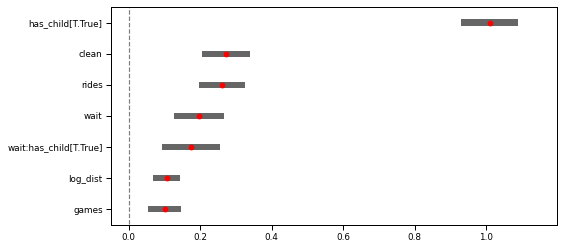

In [109]:
# 해당 결과를 다른 사람과 공유하기 위한 도식화

chapter6.plot_confidence_intervals(
    m7.params[1:], m7.conf_int().iloc[1:],
    zero_line=True
)

In [ ]:
# 모델에 상호 작용 항을 포함할 때 두가지 중요한 점
# 1. 계수에 대해 해석 가능하고 비교 가능한 척도를 갖기 위해 상호 작용을 모델링할 때 예측 변수의 표준화를 고려
# 2. 상호작용 효과를 포함할 때 항상 주 효과를 포함하기
#    주 효과를 추정하지 않으면, 의도된 상호 작용이 실제로 상호 작용으로 인한 것인이 
#    아니면 개별 변수의 추정되지 않은 주 효과 중 하나로 인한 것인이 알 수 없음

In [110]:
temp_model = smf.ols('overall ~ rides*wait',
                     data=sat_df_scaled).fit()
temp_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     200.3
Date:                Sat, 25 Feb 2023   Prob (F-statistic):           4.49e-85
Time:                        18:44:53   Log-Likelihood:                -510.58
No. Observations:                 500   AIC:                             1029.
Df Residuals:                     496   BIC:                             1046.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0112      0.032      0.352      0.725      -0.051       0.074
rides          0.4964      0.032     15.352      0.000       0.433       0.560
wait           0.3996      0.032     12.363      0.000       0.336       0.463
rides:wait    -0.0315      0.029     -1.102      0.271      -0.088       0.025
==============================================================================
Omnibus:                       14.096   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.859
Skew:                          -0.421   Prob(JB):                     0.000593
Kurtosis:                       2.944   Cond. No.                         1.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 주의! 과적합

In [111]:
# 모형에 예측 변수를 추가하면 효과 수와 변수 간의 연관성으로 인해 계수 추정치의 정확도가 떨어짐
# 이는 ols 출력에서 더 큰 계수 표준 오차로 나타나고 곧 추정치의 신뢰도가 낮음을 의미
# --> 때문에 계수에 대한 신뢰 구간을 그림

In [112]:
# 추정치에 대한 잠재적으로 낮은 신뢰도에도 불구하고 모델에 변수를 추가하면 r-squared 값이 점점 높아짐
# 첫 인상으로는 모델이 점점 좋아지는 것처럼 보일 수 있지만,
# 계수 추정치가 정확하지 않으면 모델의 유용성이 떨어짐 -> 데이터에 대한 잘못된 추론을 할 수 있음

In [ ]:
# 너무 많은 변수를 추가하고 덜 정확하거나 부적절한 모델로 끝나는 이 과정을 과적합(overfitting)이라고 함
# 이를 피하는 방법은 계수의 "표준 오차"를 면밀히 주시하는 것
# 작은 표준 오차는 모형을 추정하기에 충분한 데이터가 있음을 나타내는 지표

# 모델은 최대한 간결하게 유지하기 
# 일반적으로 명확하고 자신감 있는 해석으로 몇 가지를 식별하는 것이 마케팅 관행에서 더 가치가 있음

## 요점

In [114]:
# 1. 모델링 하기 전에 데이터 품질과 각 변수에 대한 값 분포를 확인하는 것이 중요 
#    -> 정규 분포가 선호됨, 변수에 과도한 상관관계가 없는지 확인
# 2. 가장 일반적인 표준화는 각 원소에서 각 열 평균을 빼고 열 표준편차로 나눠 수행되는 표준 편차 단위로의 변환
# 3. ols객체의 summary() 함수는 분석가가 가장 자주 검토하는 출력을 제공해 계수가 0과 다른지 여부를 평가
# 4. 상호 작용은 다른 두 예측 변수의 곱인 예측 변수이므로 예측 변수가 서로를 강화 (또는 취소)하는 정도를 평가
# 5. 모델 구축은 모델에서 예측 변수를 추가하거나 제거해 데이터에 잘 맞는 예측 변수 집합을 찾는 프로세스
#    -> r-squared를 이용하거나, 모델이 중첩된 경우 anova를 활용하여 여러 모델의 적합도 확인 가능
# 6. ols와 같은 신뢰 구간 추정 범위의 관점에서 계수를 해석하는 것이 좋음